# Прогнозирование температуры звезды

## Описание проекта
**Задача от обсерватории «Небо на ладони»**: разработать нейросеть для определения температуры на поверхности обнаруженных звёзд.

### Цель проекта
Создать модель машинного обучения, которая будет предсказывать абсолютную температуру звезды на основе её характеристик.

---

## Традиционные методы расчёта температуры
Обычно учёные используют:
1. **Закон смещения Вина**
2. **Закон Стефана-Больцмана** 
3. **Спектральный анализ**

Каждый метод имеет преимущества и недостатки. ML-подход должен стать более точной и удобной альтернативой.

---

## Данные для обучения
В базе обсерватории есть характеристики **240 изученных звёзд**:

### Признаки звезды:
| Признак | Описание |
|---------|-----------|
| **Относительная светимость** | L/Lo - светимость звезды относительно Солнца |
| **Относительный радиус** | R/Ro - радиус звезды относительно радиуса Солнца |
| **Абсолютная звёздная величина** | Mv - физическая величина, характеризующая блеск звезды |
| **Звёздный цвет** | white, red, blue, yellow, yellow-orange и др. |
| **Тип звезды** | Категориальный признак |

### Типы звезд:
| Тип звезды | Числовой код |
|------------|--------------|
| Коричневый карлик | 0 |
| Красный карлик | 1 |
| Белый карлик | 2 |
| Звёзды главной последовательности | 3 |
| Сверхгигант | 4 |
| Гипергигант | 5 |

### Целевая переменная:
- **Абсолютная температура T(K)** - температура на поверхности звезды в Кельвинах

# Импортируем библиотеки

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from IPython.display import HTML, display
import seaborn as sns
import re
import warnings
import logging

# === Библиотеки ML ===
from sklearn.model_selection import train_test_split

# === Функции проекта ===
from func import (
    EarlyStoppingCallback,
    check_data,
    drop_duplicated,
    plot_combined,
    calc_target_correlations,
)

# === Настройки ===
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    module="sklearn.feature_selection._univariate_selection",
)
warnings.filterwarnings("ignore", category=UserWarning, module="shap")

logging.getLogger("sklearn").setLevel(logging.ERROR)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)

# Константы

In [22]:
# зафиксируем константы
RANDOM_STATE = 20
TEST_SIZE = 0.25
N_JOBS = -1
N_ITER = 10 # число итераций для перебора и поиска лучших параметров
N_CROSS_VALL = 3

# Загрузка данных

In [23]:
df = pd.read_csv("../data/6_class.csv")

# Анализ и предобработка данных

In [24]:
df = check_data(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   unnamed:_0               240 non-null    int64  
 1   temperature_(_k)         240 non-null    int64  
 2   luminosity(_l/_lo)       240 non-null    float64
 3   radius(_r/_ro)           240 non-null    float64
 4   absolute_magnitude(_mv)  240 non-null    float64
 5   star_type                240 non-null    int64  
 6   star_color               240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.3+ KB


None

,unnamed:_0,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
44,44,3008,280000.0,25.000,-6.00,4,red
41,41,3365,340000.0,23.000,-6.20,4,red
237,237,8829,537493.0,1423.000,-10.73,5,white
212,212,13089,788.0,5.992,-0.12,3,blue-white
101,101,40000,813000.0,14.000,-6.23,4,blue


Series([], dtype: int64)

None

,count,mean,std,min,25%,50%,75%,max
unnamed:_0,240.0,119.500000,69.426220,0.00000,59.750000,119.5000,179.2500,239.00
temperature_(_k),240.0,10497.462500,9552.425037,1939.00000,3344.250000,5776.0000,15055.5000,40000.00
luminosity(_l/_lo),240.0,107188.361635,179432.244940,0.00008,0.000865,0.0705,198050.0000,849420.00
radius(_r/_ro),240.0,237.157781,517.155763,0.00840,0.102750,0.7625,42.7500,1948.50
absolute_magnitude(_mv),240.0,4.382396,10.532512,-11.92000,-6.232500,8.3130,13.6975,20.06
star_type,240.0,2.500000,1.711394,0.00000,1.000000,2.5000,4.0000,5.00


In [25]:
# опять непонятный unnamed:_0 который дублирует индекс
df = df.drop(columns=['unnamed:_0'])

Пропусков нет, но есть цвет звезды - проверим

In [26]:
df['star_color'].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'blue-white', 'whitish',
       'yellow-white', 'orange', 'white-yellow', 'yellowish',
       'orange-red'], dtype=object)

Так и оказалось, заполняли непонятно как... приведем неявные дубликаты к общему виду и немного наведем красоты

In [27]:
# PS: как именно обозначал автор цвета звезд, не совсем понятно.
# Возьмем первое слово = преобладающий цвет
color_mapping = {
    'blue': 'blue',
    'blue white': 'blue', 
    'blue-white': 'blue',
    
    'white': 'white',
    'whitish': 'white',
    'white-yellow': 'white',
    
    'yellow-white': 'yellow',
    'yellowish': 'yellow',
    'yellowish white': 'yellow',
    'pale yellow orange': 'yellow',
    
    'orange': 'orange',
    'orange-red': 'red',
    
    'red': 'red'
}

df['star_color'] = df['star_color'].str.strip().str.lower().replace(color_mapping)
df['star_color'].unique()

array(['red', 'blue', 'white', 'yellow', 'orange'], dtype=object)

In [28]:
df.sample(5)

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
116,4015,282000.00000,1534.00000,-11.39,5,red
6,2637,0.00073,0.12700,17.22,0,red
178,12100,120000.00000,708.90000,-7.84,5,blue
58,3752,209000.00000,955.00000,-11.24,5,red
140,13420,0.00059,0.00981,13.67,2,blue


Да, цвет звезды не совсем бьется с ее "цветовым типом", но в целом все логично.

In [29]:
# и теперь проверим явные дубликаты после корректировок
df = drop_duplicated(df)

np.int64(0)

'Дубликаты отсутствуют'

Посмотрим на распределение

2025-11-10 22:57:46 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-10 22:57:46 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


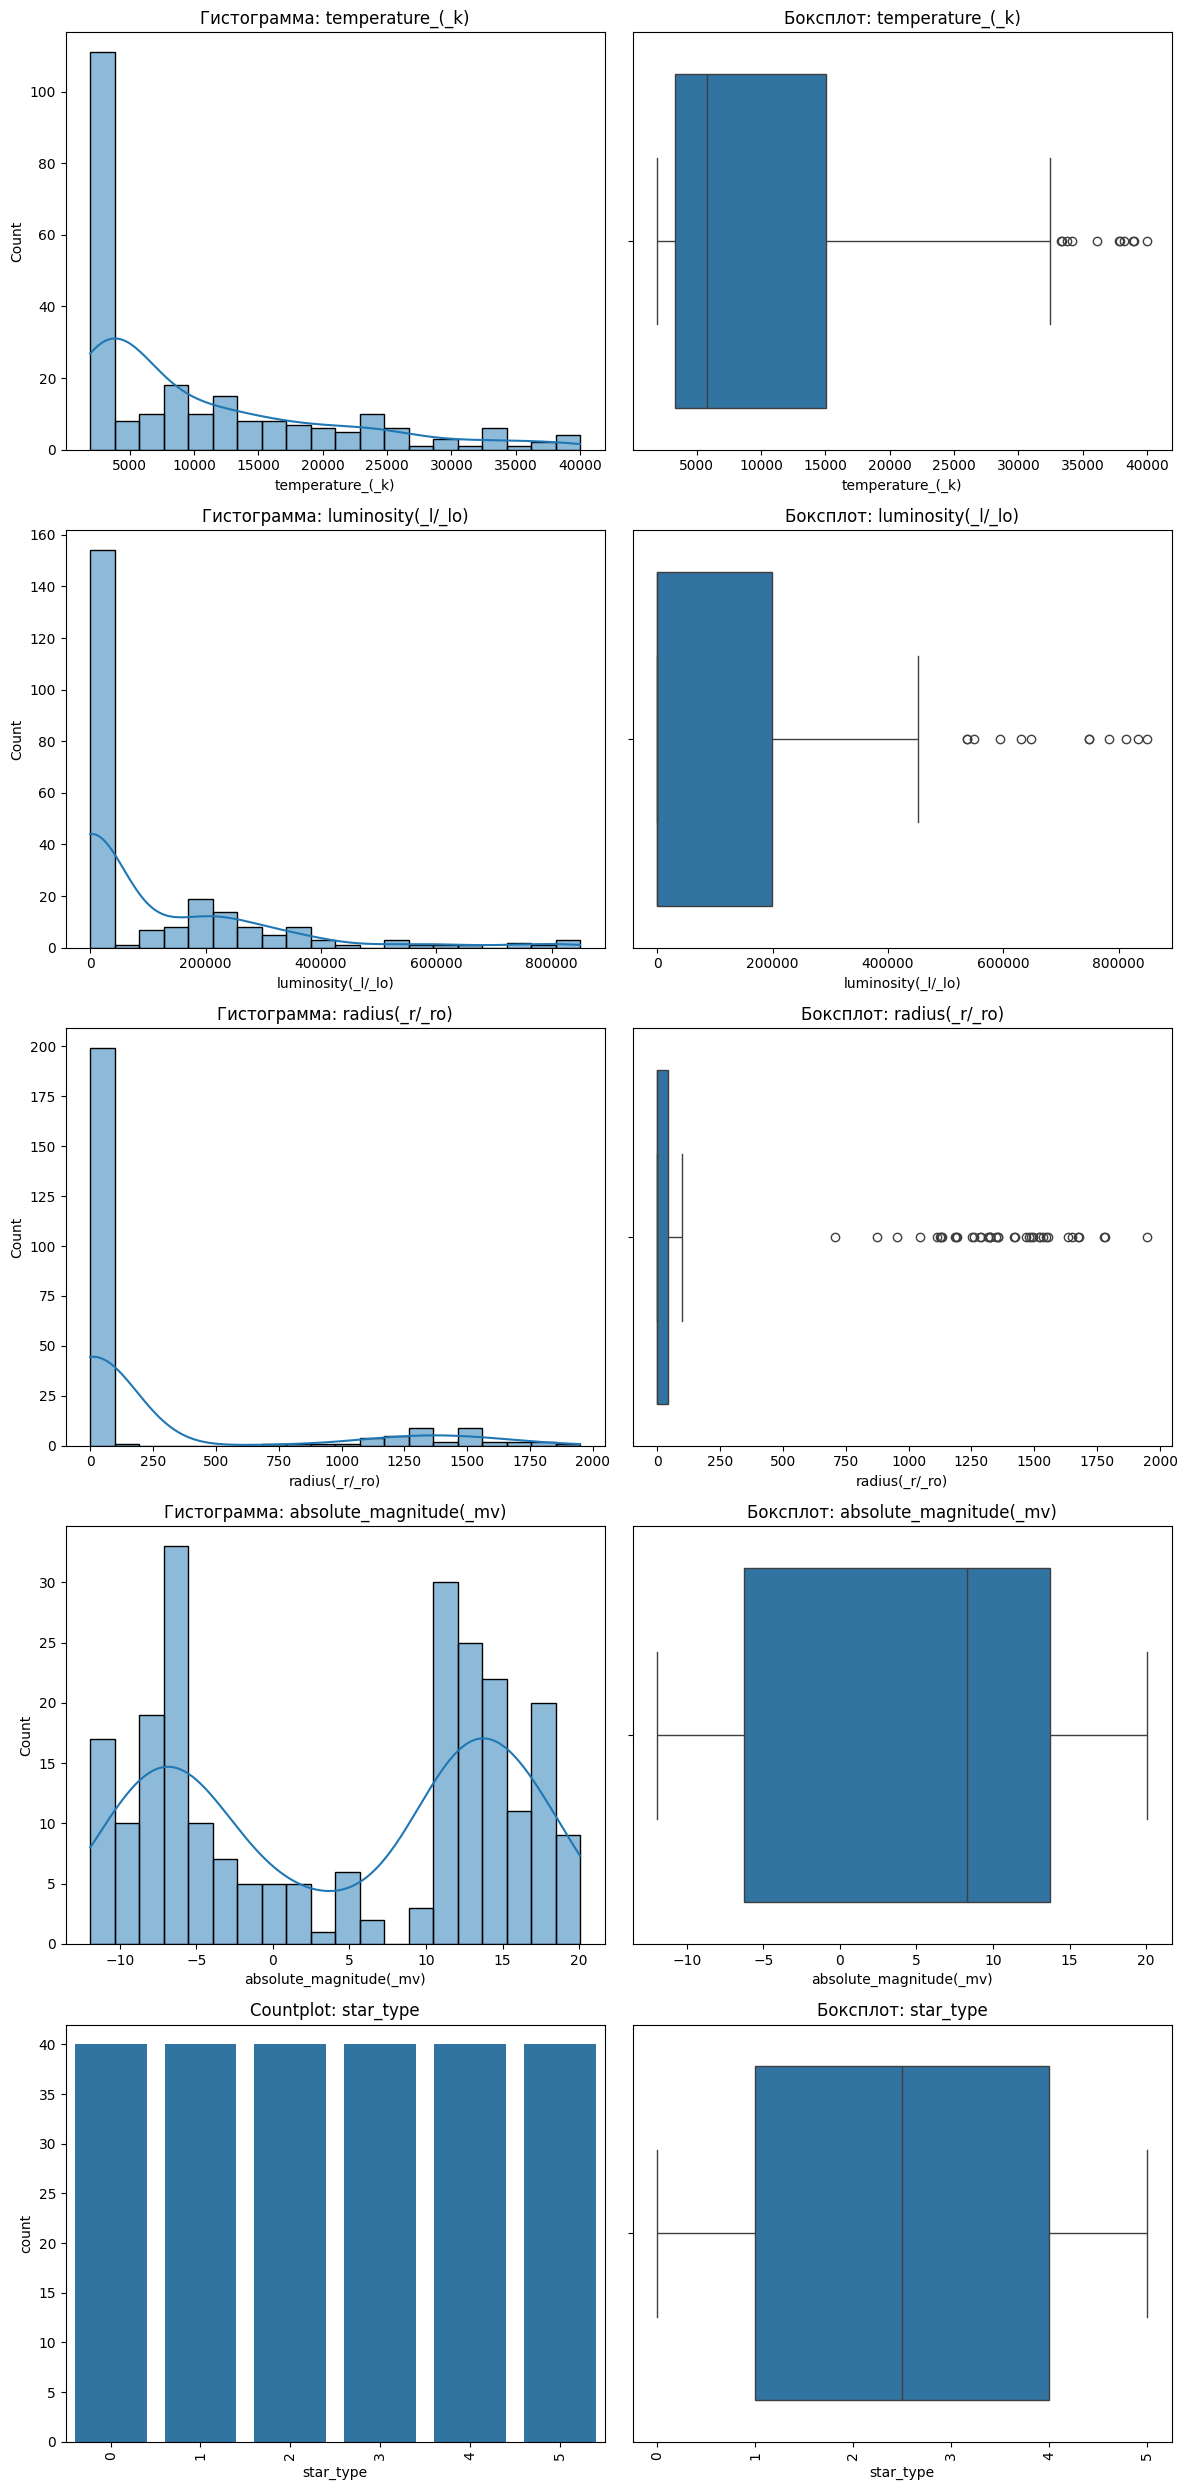

In [30]:
plot_combined(df, col=None, target=None, col_type=None, legend_loc='best')

Распределение по цвету звёзд получилось идеальным, значит теории о том, что первое слово важнее второго, подтверждается. :)  
А вот остальные признаки требуют дополнительного изучения и, наверное, обработки.

In [31]:
# очень много данных temperature_(_k) меньше 5000, посмотрим на них отдельно
df_low_temp = df[df['temperature_(_k)'] < 2000]
df_low_temp

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
4,1939,0.000138,0.103,20.06,0,red


Нулевых нет и на том спасибо.  
К томуже справочный материал говорит, что такая температура вполне возможна.

In [32]:
# и выбросы по высокой температуре
df_high_temp = df[df['temperature_(_k)'] > 35000]
df_high_temp

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
30,39000,204000.0,10.60,-4.70,3,blue
99,36108,198000.0,10.20,-4.40,3,blue
101,40000,813000.0,14.00,-6.23,4,blue
159,37800,202900.0,6.86,-4.56,3,blue
231,38234,272830.0,1356.00,-9.29,5,blue
235,38940,374830.0,1356.00,-9.93,5,blue
239,37882,294903.0,1783.00,-7.80,5,blue


Вопросики по светимости к типу 4 да и в целом все еще непонятно определение цвета звезд.  
Разные типы, разные размеры, разные светимости....  
Ничего непонятно, но очень интересно :)

Теперь свечение luminosity(_l/_lo)

In [33]:
df_low_lum = df[df['luminosity(_l/_lo)'] < 100]
df_low_lum

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
0,3068,0.002400,0.17000,16.120,0,red
1,3042,0.000500,0.15420,16.600,0,red
2,2600,0.000300,0.10200,18.700,0,red
3,2800,0.000200,0.16000,16.650,0,red
4,1939,0.000138,0.10300,20.060,0,red
...,...,...,...,...,...,...
207,23092,0.001320,0.01040,10.180,2,blue
208,17920,0.001110,0.01060,11.660,2,blue
209,19360,0.001250,0.00998,11.620,2,blue
216,9320,29.000000,1.91000,1.236,3,blue


In [34]:
df_low_lum = df[df['luminosity(_l/_lo)'] > 500000]
df_low_lum

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
53,3749,550000.0,1648.0,-8.050,5,orange
101,40000,813000.0,14.0,-6.230,4,blue
172,4287,630000.0,1315.0,-9.200,5,orange
223,23440,537430.0,81.0,-5.975,4,blue
226,9892,593900.0,80.0,-7.262,4,blue
227,10930,783930.0,25.0,-6.224,4,blue
229,21738,748890.0,92.0,-7.346,4,blue
232,32489,648430.0,1948.5,-10.840,5,blue
233,27739,849420.0,1252.0,-7.590,5,blue
234,21904,748490.0,1130.0,-7.670,5,blue


Вот о чем и писал выше - светимость огромная, а температура может быть не очень высокой.

Так как у нас идет сравнение с Солнцем, что оставим как есть.  

Радиус radius(_r/_ro) скорее всего покажет схожую картину, но посмотрим.

In [35]:
df_low_rad = df[df['radius(_r/_ro)'] < 100]
df_low_rad

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
0,3068,0.002400,0.1700,16.120,0,red
1,3042,0.000500,0.1542,16.600,0,red
2,2600,0.000300,0.1020,18.700,0,red
3,2800,0.000200,0.1600,16.650,0,red
4,1939,0.000138,0.1030,20.060,0,red
...,...,...,...,...,...,...
225,18734,224780.000000,46.0000,-7.450,4,blue
226,9892,593900.000000,80.0000,-7.262,4,blue
227,10930,783930.000000,25.0000,-6.224,4,blue
228,23095,347820.000000,86.0000,-5.905,4,blue


In [36]:
df_low_rad = df[df['radius(_r/_ro)'] > 200]
df_low_rad

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
50,3490,270000.0,1520.0,-9.40,5,red
51,3750,283000.0,1260.0,-7.63,5,red
52,3834,272000.0,1183.0,-9.20,5,red
53,3749,550000.0,1648.0,-8.05,5,orange
54,3650,310000.0,1324.0,-7.79,5,red
55,3450,263000.0,1349.0,-11.75,5,red
56,3660,363000.0,1673.0,-11.92,5,red
57,3450,174000.0,1284.0,-11.28,5,red
58,3752,209000.0,955.0,-11.24,5,red
59,3535,195000.0,1546.0,-11.36,5,red


'=== Корреляция с таргетом ==='

star_color                -0.669746
absolute_magnitude(_mv)   -0.420261
star_type                  0.411129
luminosity(_l/_lo)         0.393404
radius(_r/_ro)             0.064216
Name: temperature_(_k), dtype: float64

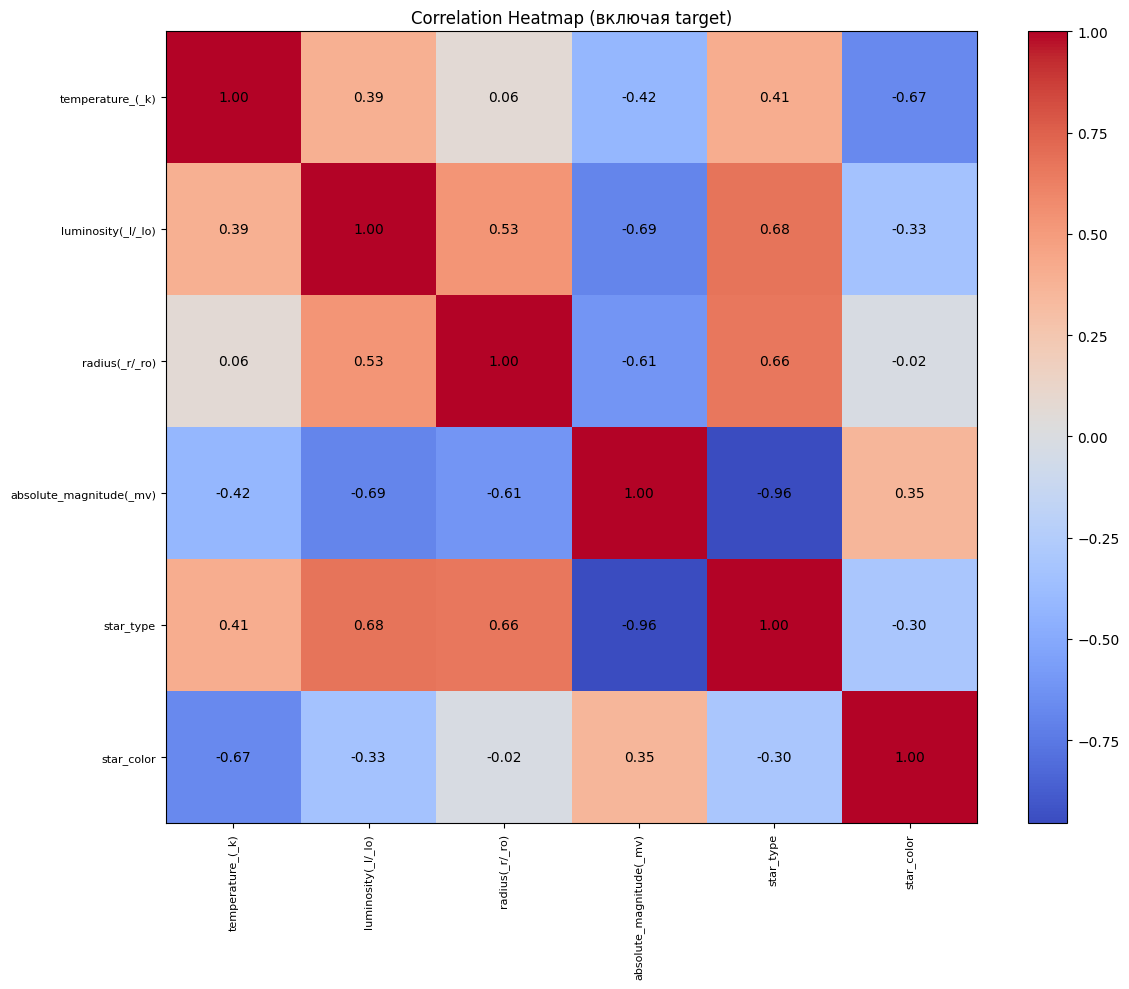

'=== VIF ==='

,feature,VIF
2,absolute_magnitude(_mv),9.108270
3,star_type,5.890457
0,luminosity(_l/_lo),2.694309
1,radius(_r/_ro),2.028803
4,star_color,1.535247


In [37]:
calc_target_correlations(df, target_col="temperature_(_k)")

Мультиколлинеарности не наблюдается.  
VIF в пределах допустимого.

## Выводы по анализу данных

**Основные проблемы в данных о звездах**  

*Несоответствие температуры и цвета*  
-- Холодные звезды указаны с цветами, характерными для горячих звезд  
-- Нарушена физическая связь между температурой и спектральным классом  

*Нарушение астрофизических законов*  
-- Не соблюдается закон Стефана-Больцмана (связь светимости с радиусом и температурой)  
-- Параметры светимости и радиуса противоречат друг другу  

*Статистические аномалии*  
-- Слишком много редких типов звезд (гипергигантов)  
-- Нарушены реальные пропорции встречаемости разных классов звезд  

*Проблемы с классификацией*  
-- Цвета звезд не соответствуют их физическим параметрам  
-- Отсутствует системный подход к классификации по спектральным классам  
-- Произвольное сочетание характеристик без физического обоснования  

*Методологические проблемы*  
-- Данные выглядят сгенерированными, а не наблюдаемыми  
-- Отсутствует внутренняя согласованность параметров  
-- Нарушены известные астрофизические зависимости  

В целом: Данные требуют серьезной доработки для соответствия реальным астрономическим закономерностям.  
Но ввиду того, что это учебный проект, будем работать с тем, что есть.  

# Построение базовой нейронной сети

## Разделение данных на признаки и целевой признак

In [38]:
# разделим на выборки их оставшихся данных
target = 'temperature_(_k)'
X_train, X_test, y_train, y_test = train_test_split(
    df.drop([target], axis=1),
    df[target],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

# Улучшение нейронной сети

# Выводы